In [115]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import optuna

In [116]:
torch.manual_seed(42) ## For reproducibility

In [117]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [118]:
df_train = pd.read_csv('fashion-mnist_train.csv')

In [119]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


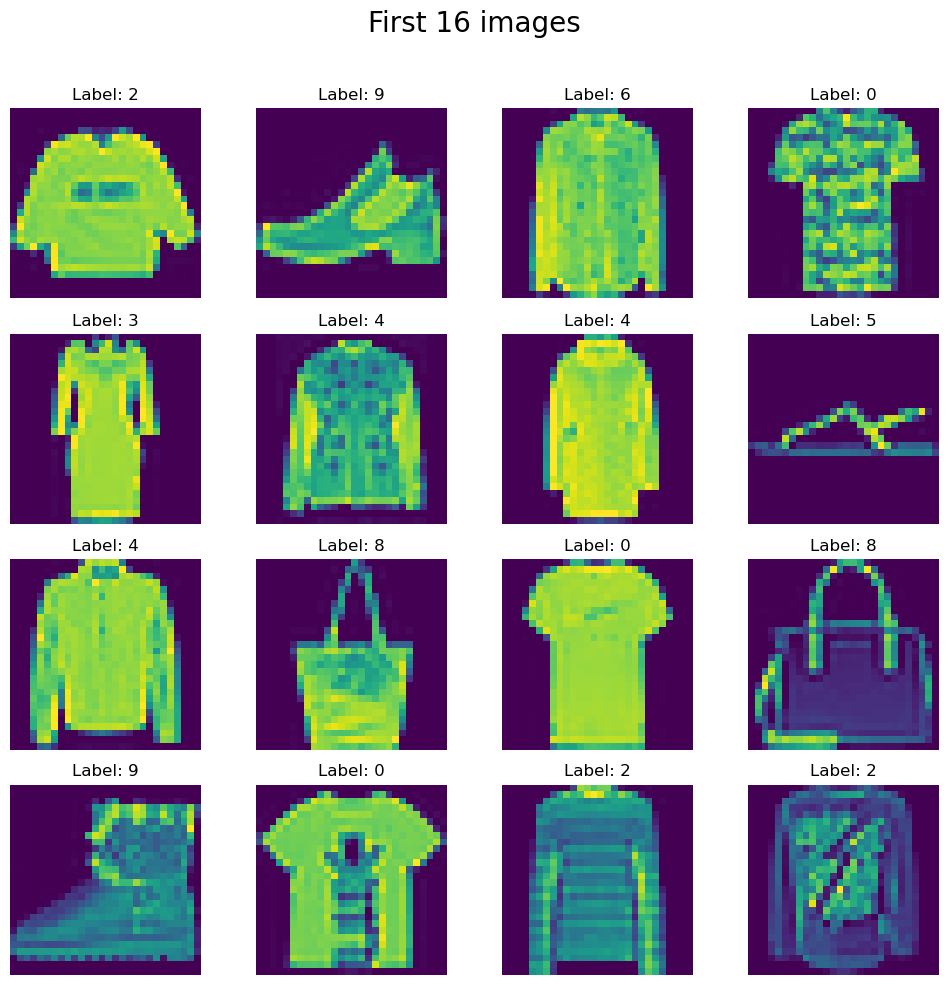

In [120]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 images", fontsize=20)

for i, ax in enumerate(axes.flat):
    img = df_train.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df_train.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [121]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

In [122]:
df_test = pd.read_csv('fashion-mnist_test.csv')
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [123]:
# scaling the features
X_train = X_train / 255.0
X_test = X_test / 255.0

In [124]:
# create a custom dataset class
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

        

In [125]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [126]:
len(train_dataset)

60000

In [127]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [128]:
test_dataset = CustomDataset(X_test, y_test)

In [129]:
# define NN Class

class NeuralNetwork(nn.Module):

    def __init__(self, input_dim, output_dim, num_hidden_layer, neurons_per_layer, dropout_rate):

        super().__init__()

        layers = []
        
        for i in range(num_hidden_layer):

            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, output_dim))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        

In [130]:

def objective(trial):

    # next hyperparameter vales from search space
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float("Weight_decay", 1e-5, 1e-3, log=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # model init
    input_dim = 784
    output_dim = 10
    
    model = NeuralNetwork(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
    model.to(device)
    # optimizer select
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # training loop
    for epoch in range(epochs):

        total_epoch_loss = 0

        for batch_features, batch_labels in train_loader:
            
            # move to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            # forward pass
            outputs = model(batch_features)
            # loss calculation
            loss = criterion(outputs, batch_labels)
            # back propagation
            optimizer.zero_grad()
            loss.backward()
            # update gradients
            optimizer.step()
            
    # evaluation
    model.eval()

    # evaluation  code for testing data
    total = 0
    correct = 0

    with torch.no_grad():

        for batch_features, batch_labels in test_loader:
            # move to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()
        
        accuracy = (correct/total)

    
    return accuracy

In [131]:
study = optuna.create_study(direction='maximize')

[I 2025-04-07 12:29:22,600] A new study created in memory with name: no-name-0bbe8011-e93e-4338-a193-0fe3386503e9


In [132]:
study.optimize(objective, n_trials=10)

[I 2025-04-07 12:31:49,577] Trial 0 finished with value: 0.829 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 32, 'epochs': 30, 'learning_rate': 0.0012317727616211996, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'RMSprop', 'Weight_decay': 0.0003768877611948246}. Best is trial 0 with value: 0.829.
[I 2025-04-07 12:35:09,447] Trial 1 finished with value: 0.8918 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 72, 'epochs': 40, 'learning_rate': 0.01852288188669062, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer': 'SGD', 'Weight_decay': 1.0996107276487474e-05}. Best is trial 1 with value: 0.8918.
[I 2025-04-07 12:42:04,692] Trial 2 finished with value: 0.865 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 88, 'epochs': 60, 'learning_rate': 0.005594553037808229, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam', 'Weight_decay': 6.299385388230824e-05}. Best is trial 1 with value: 0.8918.
[I 2025-04-07 12:47:16,661]

In [133]:
study.best_value

0.8984

In [134]:
study.best_params

{'num_hidden_layers': 3,
 'neurons_per_layer': 88,
 'epochs': 50,
 'learning_rate': 0.03236602448490338,
 'dropout_rate': 0.1,
 'batch_size': 32,
 'optimizer': 'SGD',
 'Weight_decay': 0.00018273760723377193}